In [56]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

from joblib import dump

from dotenv import set_key

In [57]:
df = pd.read_csv("database/casks_database__casks_valuation.csv")
df

,auction_date,distillery,region,country,strength,rla,bulk_litres,distillery_status,cask_type,cask_filling,...,age,bottles_at_cask_strength,volume_12m,volume_6m,volume_3m,inf_adj_hammer_price,inf_adj_hammer_price_per_bottle_at_cask_strength,inf_adj_hammer_price_per_litre_of_alcohol,inf_adj_hammer_price_per_litre_of_alcohol_per_age,inf_adj_hammer_price_per_age
0,2025-01-06,Bruichladdich,Islay,Scotland,50.4,74.90,148.61,Operational,Barrel,First Fill,...,20.00,212.30,105,63,26,19060.19,89.78,254.48,12.72,953.01
1,2025-01-06,Copper House,England,England,64.8,74.78,115.40,Operational,Barrel,NaN,...,13.00,164.86,105,63,26,1030.28,6.25,13.78,1.06,79.25
2,2024-12-02,Copper House,England,England,64.8,74.78,115.40,Operational,Barrel,NaN,...,13.00,164.86,132,70,45,1028.76,6.24,13.76,1.06,79.14
3,2024-10-07,Dailuaine,Speyside,Scotland,59.3,125.73,212.02,Operational,Hogshead,Second Fill,...,15.00,302.89,124,67,37,3587.73,11.84,28.54,1.90,239.18
4,2024-10-07,Dailuaine,Islay,Scotland,61.0,122.00,200.00,Operational,Hogshead,Second Fill,...,8.00,285.71,124,67,37,1808.33,6.33,14.82,1.85,226.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2024-09-08,Undisclosed Distillery,Lowlands,Scotland,62.8,139.79,222.60,NaN,Hogshead,NaN,...,3.69,318.00,100,45,25,3118.48,9.81,22.31,6.05,845.12
251,2024-09-08,Undisclosed Distillery,Lowlands,Scotland,62.3,136.13,218.50,NaN,Hogshead,NaN,...,3.69,312.14,100,45,25,3118.48,9.99,22.91,6.21,845.12
252,2024-09-08,Undisclosed Distillery,Lowlands,Scotland,62.6,140.91,225.10,NaN,Hogshead,NaN,...,3.69,321.57,100,45,25,3118.48,9.70,22.13,6.00,845.12
253,2024-09-08,Undisclosed Distillery,Lowlands,Scotland,63.1,147.53,233.80,NaN,Hogshead,NaN,...,3.69,334.00,100,45,25,3118.48,9.34,21.14,5.73,845.12


In [58]:
# Transforms date columns to datetime format

df['auction_date'] = pd.to_datetime(df['auction_date'], format='%Y-%m-%d')
# df['year'] = df['auction_date'].dt.year
# df['month'] = df['auction_date'].dt.month
# df

In [59]:
df.sort_values('auction_date', ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)

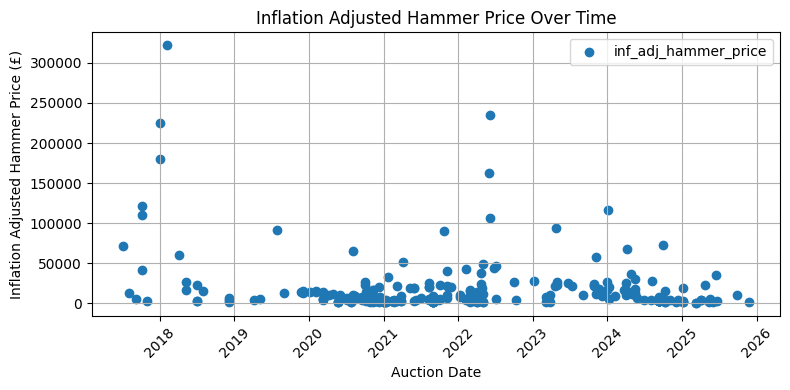

In [60]:
plt.figure(figsize=(8, 4))
plt.scatter(df['auction_date'], df['inf_adj_hammer_price'], label='inf_adj_hammer_price', marker='o')
plt.title('Inflation Adjusted Hammer Price Over Time')
plt.xlabel('Auction Date')
plt.ylabel('Inflation Adjusted Hammer Price (£)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

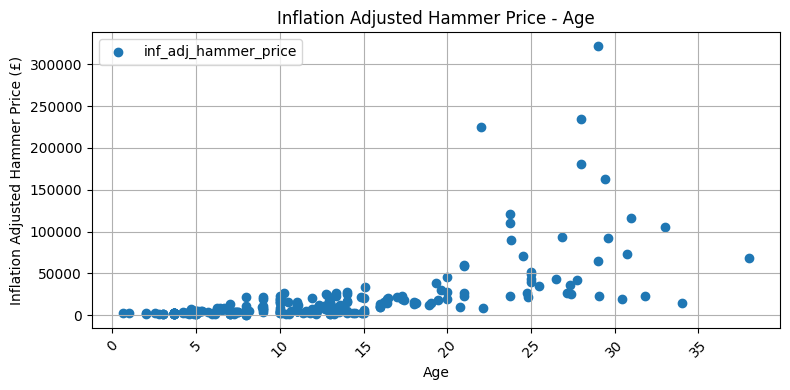

In [61]:
plt.figure(figsize=(8, 4))
plt.scatter(df['age'], df['inf_adj_hammer_price'], label='inf_adj_hammer_price', marker='o')
plt.title('Inflation Adjusted Hammer Price - Age')
plt.xlabel('Age')
plt.ylabel('Inflation Adjusted Hammer Price (£)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

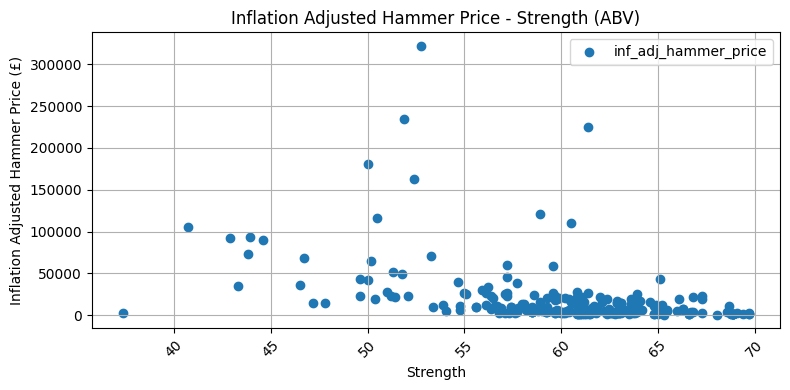

In [62]:
plt.figure(figsize=(8, 4))
plt.scatter(df['strength'], df['inf_adj_hammer_price'], label='inf_adj_hammer_price', marker='o')
plt.title('Inflation Adjusted Hammer Price - Strength (ABV)')
plt.xlabel('Strength')
plt.ylabel('Inflation Adjusted Hammer Price (£)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Data preparation

In [63]:
df.isnull().sum()

auction_date                                           0
distillery                                             0
region                                                 0
country                                                0
strength                                               0
rla                                                    0
bulk_litres                                            0
distillery_status                                     15
cask_type                                             20
cask_filling                                         125
previous_spirit                                       14
age                                                    0
bottles_at_cask_strength                               0
volume_12m                                             0
volume_6m                                              0
volume_3m                                              0
inf_adj_hammer_price                                   0
inf_adj_hammer_price_per_bottle

In [64]:
# Drop unused columns
df.drop(columns=['inf_adj_hammer_price_per_bottle_at_cask_strength'], inplace=True)

In [65]:
# Drop columns with too much NaN values
df.drop(columns=['cask_filling', 'distillery_status'], inplace=True)
df

,auction_date,distillery,region,country,strength,rla,bulk_litres,cask_type,previous_spirit,age,bottles_at_cask_strength,volume_12m,volume_6m,volume_3m,inf_adj_hammer_price,inf_adj_hammer_price_per_litre_of_alcohol,inf_adj_hammer_price_per_litre_of_alcohol_per_age,inf_adj_hammer_price_per_age
0,2025-11-23,Annandale,Lowlands,Scotland,63.5,126.17,198.70,Barrel,Bourbon,4.89,283.860000,78,12,1,1375.00,10.90,2.23,281.19
1,2025-09-28,Bruichladdich,Islay,Scotland,53.4,66.75,125.00,Barrel,Bourbon,20.74,178.570000,112,28,6,10114.50,151.53,7.31,487.68
2,2025-06-22,Ardmore,Highlands,Scotland,57.6,92.62,160.80,Barrel,Bourbon,14.47,229.710000,131,61,22,2309.94,24.94,1.72,159.64
3,2025-06-16,Springbank,Campbeltown,Scotland,43.3,57.90,131.80,Hogshead,Bourbon,25.46,188.285714,131,61,22,35151.19,607.10,23.85,1380.64
4,2025-06-02,Tullibardine,Highlands,Scotland,69.4,109.00,157.06,Barrel,NaN,7.24,224.370000,131,61,22,1531.59,14.05,1.94,211.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2017-10-04,Macallan,Speyside,Scotland,58.9,58.90,141.09,Hogshead,Sherry,23.76,201.560000,7,7,5,121292.71,2059.30,86.67,5104.91
251,2017-10-04,Macallan,Speyside,Scotland,60.5,60.50,186.45,Hogshead,Sherry,23.76,266.360000,7,7,5,109913.15,1816.75,76.46,4625.97
252,2017-09-06,Tullibardine,Highlands,Scotland,59.0,59.00,168.00,Barrel,Bourbon,10.68,240.000000,6,6,5,4958.21,84.04,7.87,464.25
253,2017-08-02,Bruichladdich,Islay,Scotland,53.9,53.90,162.00,Barrel,Bourbon,13.59,231.430000,5,5,5,12498.55,231.88,17.06,919.69


In [66]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.isnull().sum()

auction_date                                         0
distillery                                           0
region                                               0
country                                              0
strength                                             0
rla                                                  0
bulk_litres                                          0
cask_type                                            0
previous_spirit                                      0
age                                                  0
bottles_at_cask_strength                             0
volume_12m                                           0
volume_6m                                            0
volume_3m                                            0
inf_adj_hammer_price                                 0
inf_adj_hammer_price_per_litre_of_alcohol            0
inf_adj_hammer_price_per_litre_of_alcohol_per_age    0
inf_adj_hammer_price_per_age                         0
dtype: int

In [67]:
df

,auction_date,distillery,region,country,strength,rla,bulk_litres,cask_type,previous_spirit,age,bottles_at_cask_strength,volume_12m,volume_6m,volume_3m,inf_adj_hammer_price,inf_adj_hammer_price_per_litre_of_alcohol,inf_adj_hammer_price_per_litre_of_alcohol_per_age,inf_adj_hammer_price_per_age
0,2025-11-23,Annandale,Lowlands,Scotland,63.5,126.17,198.70,Barrel,Bourbon,4.89,283.860000,78,12,1,1375.00,10.90,2.23,281.19
1,2025-09-28,Bruichladdich,Islay,Scotland,53.4,66.75,125.00,Barrel,Bourbon,20.74,178.570000,112,28,6,10114.50,151.53,7.31,487.68
2,2025-06-22,Ardmore,Highlands,Scotland,57.6,92.62,160.80,Barrel,Bourbon,14.47,229.710000,131,61,22,2309.94,24.94,1.72,159.64
3,2025-06-16,Springbank,Campbeltown,Scotland,43.3,57.90,131.80,Hogshead,Bourbon,25.46,188.285714,131,61,22,35151.19,607.10,23.85,1380.64
4,2025-05-19,Arran,Highlands,Scotland,58.6,134.00,226.00,Hogshead,Sherry,12.21,322.857143,134,66,22,5342.12,39.87,3.27,437.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,2017-10-04,Macallan,Speyside,Scotland,58.9,58.90,141.09,Hogshead,Sherry,23.76,201.560000,7,7,5,121292.71,2059.30,86.67,5104.91
217,2017-10-04,Macallan,Speyside,Scotland,60.5,60.50,186.45,Hogshead,Sherry,23.76,266.360000,7,7,5,109913.15,1816.75,76.46,4625.97
218,2017-09-06,Tullibardine,Highlands,Scotland,59.0,59.00,168.00,Barrel,Bourbon,10.68,240.000000,6,6,5,4958.21,84.04,7.87,464.25
219,2017-08-02,Bruichladdich,Islay,Scotland,53.9,53.90,162.00,Barrel,Bourbon,13.59,231.430000,5,5,5,12498.55,231.88,17.06,919.69


In [68]:
df['distillery'] = df['distillery'].str.lower()
df['region'] = df['region'].str.lower()
df['country'] = df['country'].str.lower()
df['cask_type'] = df['cask_type'].str.lower()
df['previous_spirit'] = df['previous_spirit'].str.lower()

### Outliers filtering

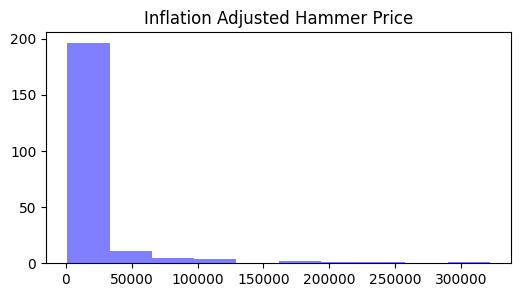

In [69]:
plt.figure(figsize=(6, 3))
plt.hist(df['inf_adj_hammer_price'], color='blue', alpha=0.5)
plt.title('Inflation Adjusted Hammer Price')
plt.show()

In [70]:
Q1 = df['inf_adj_hammer_price'].quantile(0.25)
Q3 = df['inf_adj_hammer_price'].quantile(0.75)
IQR = Q3 - Q1

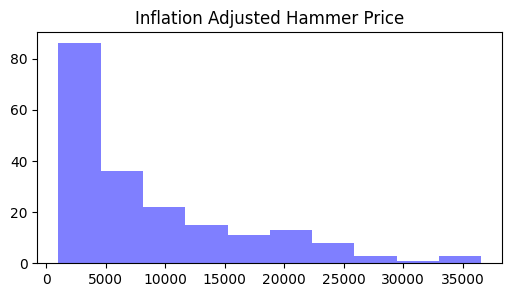

In [71]:

filtro = (df['inf_adj_hammer_price'] >= (Q1 - 1.5 * IQR)) & (df['inf_adj_hammer_price'] <= (Q3 + 1.5 * IQR)) & (df['strength'] >= 40)
df = df[filtro].reset_index(drop=True)
plt.figure(figsize=(6, 3))
plt.hist(df['inf_adj_hammer_price'], color='blue', alpha=0.5)
plt.title('Inflation Adjusted Hammer Price')
plt.show()

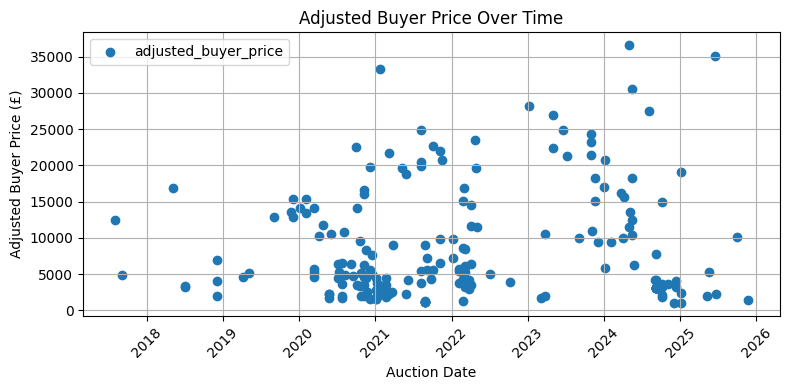

In [72]:
plt.figure(figsize=(8, 4))
plt.scatter(df['auction_date'], df['inf_adj_hammer_price'], label='adjusted_buyer_price', marker='o')
plt.title('Adjusted Buyer Price Over Time')
plt.xlabel('Auction Date')
plt.ylabel('Adjusted Buyer Price (£)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

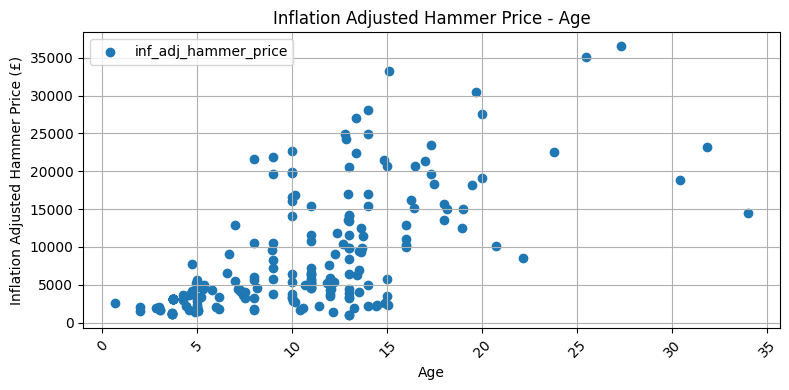

In [73]:
plt.figure(figsize=(8, 4))
plt.scatter(df['age'], df['inf_adj_hammer_price'], label='inf_adj_hammer_price', marker='o')
plt.title('Inflation Adjusted Hammer Price - Age')
plt.xlabel('Age')
plt.ylabel('Inflation Adjusted Hammer Price (£)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

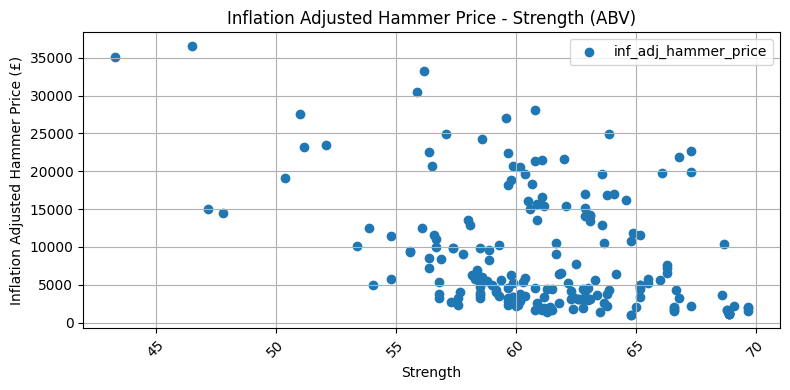

In [74]:
plt.figure(figsize=(8, 4))
plt.scatter(df['strength'], df['inf_adj_hammer_price'], label='inf_adj_hammer_price', marker='o')
plt.title('Inflation Adjusted Hammer Price - Strength (ABV)')
plt.xlabel('Strength')
plt.ylabel('Inflation Adjusted Hammer Price (£)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [75]:
df.drop(columns=['auction_date'], inplace=True)

### Log transformation

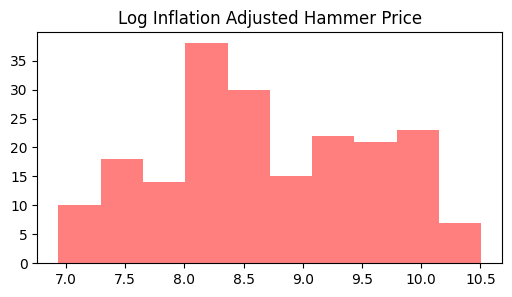

In [76]:
plt.figure(figsize=(6, 3))
plt.hist(np.log(df['inf_adj_hammer_price']), color='red', alpha=0.5)
plt.title('Log Inflation Adjusted Hammer Price')
plt.show()

### Box-Cox transformation

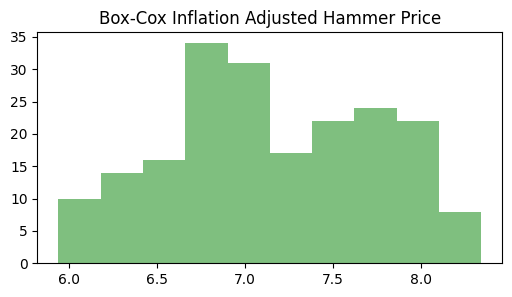

In [77]:
# Supondo que seus dados estejam em y
y_boxcox, fitted_lambda = boxcox(df['inf_adj_hammer_price'])

plt.figure(figsize=(6, 3))
plt.hist(y_boxcox, color='green', alpha=0.5)
plt.title('Box-Cox Inflation Adjusted Hammer Price')
plt.show()

# Feature selection

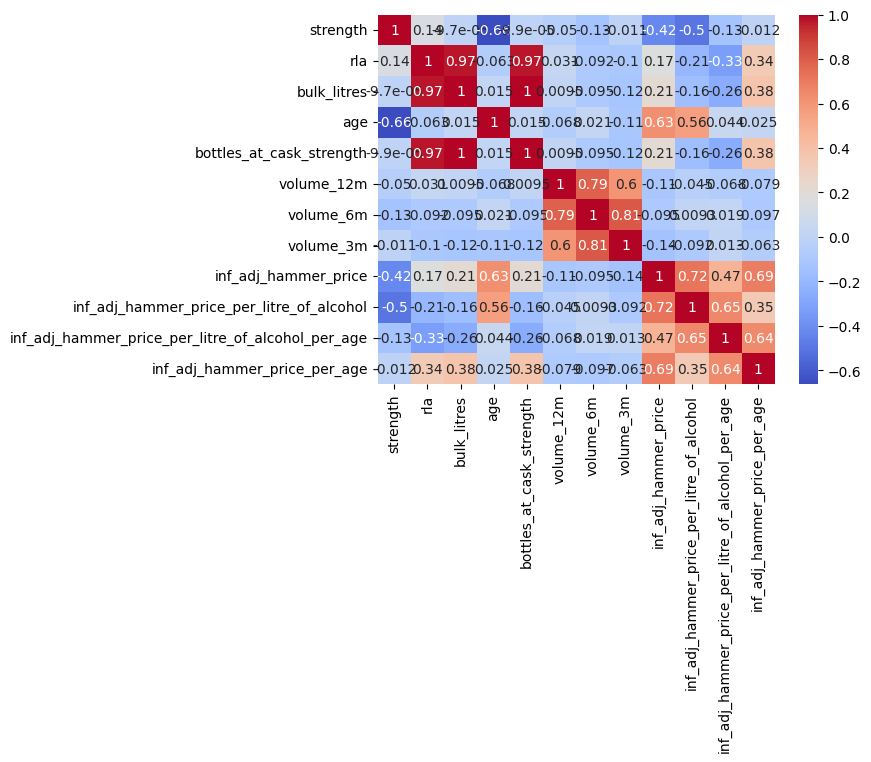

In [78]:
corr = df.drop(['distillery', 'region', 'country', 'cask_type', 'previous_spirit'], axis=1).corr(method='pearson')

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [79]:
# Drop column with high correlation to 'Rla'
df_correlation_selection = df.drop(columns=['bulk_litres', 'bottles_at_cask_strength'])

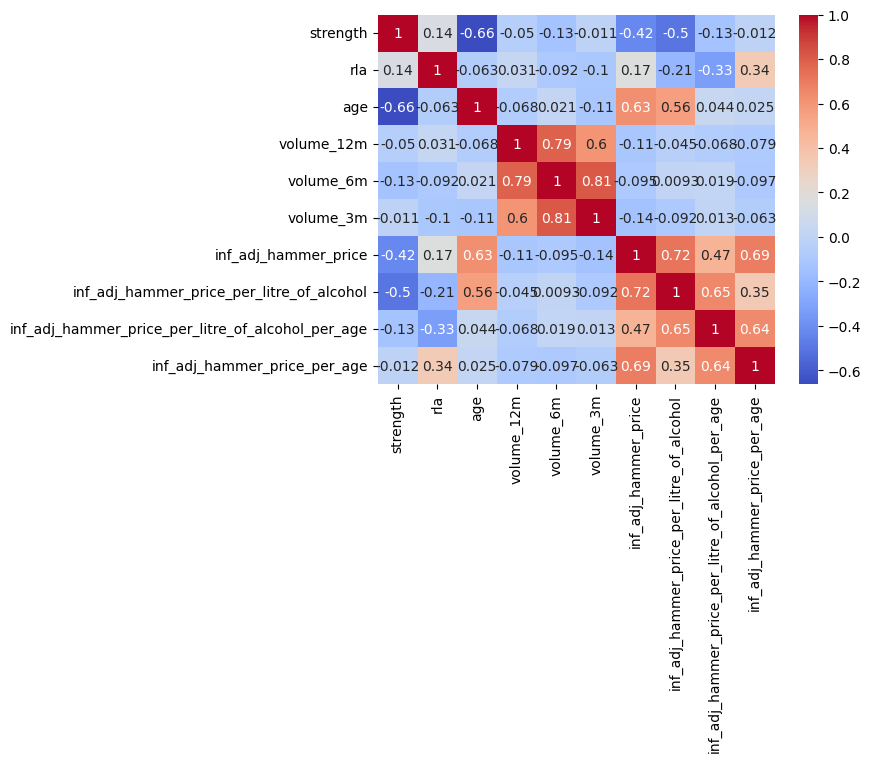

In [80]:
corr = df_correlation_selection.drop(['distillery', 'region', 'country', 'cask_type', 'previous_spirit'], axis=1).corr(method='pearson')

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

### One hot encoding for categorical variables

In [81]:
df = pd.get_dummies(df, columns=['distillery', 'region', 'country', 'cask_type', 'previous_spirit'], drop_first=True, dtype=int)

In [82]:
df_correlation_selection = pd.get_dummies(df_correlation_selection,
                                          columns=['distillery', 'region', 'country', 'cask_type', 'previous_spirit'],
                                          drop_first=True, dtype=int)

# Split train and test data

In [83]:
x = df.drop(columns=['inf_adj_hammer_price', 'inf_adj_hammer_price_per_litre_of_alcohol_per_age',
                     'inf_adj_hammer_price_per_age', 'inf_adj_hammer_price_per_litre_of_alcohol'])

all_numeric_columns = ['strength', 'bulk_litres', 'rla', 'age', 'bottles_at_cask_strength', 'volume_12m', 'volume_6m', 'volume_3m']

In [84]:
x_columns_all_features = x.columns.to_list()

x_columns_corr_sel = x.drop(columns=['bulk_litres', 'bottles_at_cask_strength']).columns.to_list()

In [85]:
y_standard = df['inf_adj_hammer_price']

x_train_standard, x_test_standard, y_train_standard, y_test_standard = train_test_split(x, y_standard, test_size=0.20, random_state=42)

# Log transformation
y_train_log_standard = np.log(y_train_standard)

# Box-Cox transformation
y_train_boxcox_standard, fitted_lambda_standard = boxcox(y_train_standard)

scaler_x_standard = StandardScaler()

x_train_standard_scaled = x_train_standard.copy()
x_train_standard_scaled[all_numeric_columns] = scaler_x_standard.fit_transform(x_train_standard[all_numeric_columns])

x_test_standard_scaled = x_test_standard.copy()
x_test_standard_scaled[all_numeric_columns] = scaler_x_standard.transform(x_test_standard[all_numeric_columns])

x_train_corr_sel_standard_scaled = x_train_standard_scaled[x_columns_corr_sel]
x_test_corr_sel_standard_scaled = x_test_standard_scaled[x_columns_corr_sel]

x_train_corr_sel_standard = x_train_standard[x_columns_corr_sel]
x_test_corr_sel_standard = x_test_standard[x_columns_corr_sel]

In [86]:
y_per_rla = df['inf_adj_hammer_price_per_litre_of_alcohol']

x_train_per_rla, x_test_per_rla, y_train_per_rla, y_test_per_rla = train_test_split(x, y_per_rla, test_size=0.20, random_state=42)

# Log transformation
y_train_log_per_rla = np.log(y_train_per_rla)

# Box-Cox transformation
y_train_boxcox_per_rla, fitted_lambda_per_rla = boxcox(y_train_per_rla)

scaler_x_per_rla = StandardScaler()

x_train_per_rla_scaled = x_train_per_rla.copy()
x_train_per_rla_scaled[all_numeric_columns] = scaler_x_per_rla.fit_transform(x_train_per_rla[all_numeric_columns])

x_test_per_rla_scaled = x_test_per_rla.copy()
x_test_per_rla_scaled[all_numeric_columns] = scaler_x_per_rla.transform(x_test_per_rla[all_numeric_columns])

x_train_corr_sel_per_rla_scaled = x_train_per_rla_scaled[x_columns_corr_sel]
x_test_corr_sel_per_rla_scaled = x_test_per_rla_scaled[x_columns_corr_sel]

x_train_corr_sel_per_rla = x_train_per_rla[x_columns_corr_sel]
x_test_corr_sel_per_rla = x_test_per_rla[x_columns_corr_sel]

In [87]:
y_per_rla_per_age = df['inf_adj_hammer_price_per_litre_of_alcohol_per_age']

x_train_per_rla_per_age, x_test_per_rla_per_age, y_train_per_rla_per_age, y_test_per_rla_per_age = train_test_split(x, y_per_rla_per_age, test_size=0.20, random_state=42)

# Log transformation
y_train_log_per_rla_per_age = np.log(y_train_per_rla_per_age)

# Box-Cox transformation
y_train_boxcox_per_rla_per_age, fitted_lambda_per_rla_per_age = boxcox(y_train_per_rla_per_age)

scaler_x_per_rla_per_age = StandardScaler()

x_train_per_rla_per_age_scaled = x_train_per_rla_per_age.copy()
x_train_per_rla_per_age_scaled[all_numeric_columns] = scaler_x_per_rla_per_age.fit_transform(x_train_per_rla_per_age[all_numeric_columns])

x_test_per_rla_per_age_scaled = x_test_per_rla_per_age.copy()
x_test_per_rla_per_age_scaled[all_numeric_columns] = scaler_x_per_rla_per_age.transform(x_test_per_rla_per_age[all_numeric_columns])

x_train_corr_sel_per_rla_per_age_scaled = x_train_per_rla_per_age_scaled[x_columns_corr_sel]
x_test_corr_sel_per_rla_per_age_scaled = x_test_per_rla_per_age_scaled[x_columns_corr_sel]

x_train_corr_sel_per_rla_per_age = x_train_per_rla_per_age[x_columns_corr_sel]
x_test_corr_sel_per_rla_per_age = x_test_per_rla_per_age[x_columns_corr_sel]

In [88]:
y_per_age = df['inf_adj_hammer_price_per_age']

x_train_per_age, x_test_per_age, y_train_per_age, y_test_per_age = train_test_split(x, y_per_age, test_size=0.20, random_state=42)

# Log transformation
y_train_log_per_age = np.log(y_train_per_age)

# Box-Cox transformation
y_train_boxcox_per_age, fitted_lambda_per_age = boxcox(y_train_per_age)

scaler_x_per_age = StandardScaler()

x_train_per_age_scaled = x_train_per_age.copy()
x_train_per_age_scaled[all_numeric_columns] = scaler_x_per_age.fit_transform(x_train_per_age[all_numeric_columns])

x_test_per_age_scaled = x_test_per_age.copy()
x_test_per_age_scaled[all_numeric_columns] = scaler_x_per_age.transform(x_test_per_age[all_numeric_columns])

x_train_corr_sel_per_age_scaled = x_train_per_age_scaled[x_columns_corr_sel]
x_test_corr_sel_per_age_scaled = x_test_per_age_scaled[x_columns_corr_sel]

x_train_corr_sel_per_age = x_train_per_age[x_columns_corr_sel]
x_test_corr_sel_per_age = x_test_per_age[x_columns_corr_sel]

In [89]:
dump(fitted_lambda_standard, 'features/fitted_lambda_standard.pkl')
dump(fitted_lambda_per_rla, 'features/fitted_lambda_per_rla.pkl')
dump(fitted_lambda_per_rla_per_age, 'features/fitted_lambda_per_rla_per_age.pkl')
dump(fitted_lambda_per_age, 'features/fitted_lambda_per_age.pkl')

dump(x_columns_corr_sel, 'features/x_columns_corr_sel.pkl')

['features/x_columns_corr_sel.pkl']

In [90]:
set_key('.env', 'fitted_lambda_standard', str(fitted_lambda_standard))
set_key('.env', 'fitted_lambda_per_rla', str(fitted_lambda_per_rla))
set_key('.env', 'fitted_lambda_per_rla_per_age', str(fitted_lambda_per_rla_per_age))
set_key('.env', 'fitted_lambda_per_age', str(fitted_lambda_per_age))

set_key('.env', 'x_columns_corr_sel', ",".join(x_columns_corr_sel))
set_key('.env', 'x_columns_all_features', ",".join(x_columns_all_features))

(True,
 'x_columns_all_features',
 'strength,rla,bulk_litres,age,bottles_at_cask_strength,volume_12m,volume_6m,volume_3m,distillery_ardmore,distillery_arran,distillery_aultmore,distillery_ben nevis,distillery_benriach,distillery_blair athol,distillery_bonnington,distillery_bruichladdich,distillery_bunnahabhain,distillery_caol ila,distillery_copper house,distillery_craigellachie,distillery_dailuaine,distillery_dalmunach,distillery_dingle,distillery_dufftown,distillery_fettercairn,distillery_girvan,distillery_glasgow,distillery_glen elgin,distillery_glen garioch,distillery_glen moray,distillery_glen ord,distillery_glen spey,distillery_glenallachie,distillery_glenburgie,distillery_glenfarclas,distillery_glenglassaugh,distillery_glenlossie,distillery_glenrothes,distillery_glentauchers,distillery_heaven hill,distillery_inchgower,distillery_invergordon,distillery_knockdhu,distillery_lochindaal (bruichladdich),distillery_longmorn,distillery_north british,distillery_port charlotte,distillery_p

In [91]:
dump(scaler_x_standard, 'scalers/scaler_x_standard.pkl')
dump(scaler_x_per_rla, 'scalers/scaler_x_per_rla.pkl')
dump(scaler_x_per_rla_per_age, 'scalers/scaler_x_per_rla_per_age.pkl')
dump(scaler_x_per_age, 'scalers/scaler_x_per_age.pkl')

['scalers/scaler_x_per_age.pkl']

In [92]:
models_metrics = []
trained_models = {}

# Model training and evaluation

In [93]:
import warnings
warnings.filterwarnings("ignore")

In [94]:
models_metrics = []
trained_models = {}

x_features = ['All features', 'Correlation selected features']
x_features_transformation = ['No transformation', 'Log transformation', 'Box-Cox transformation']
y_variables = ['Inflation Adjusted Hammer Price',
               'Inflation Adjusted Hammer Price per Litre of Alcohol',
               'Inflation Adjusted Hammer Price per Age',
               'Inflation Adjusted Hammer Price per Litre of Alcohol per Age']

In [95]:
def set_variables(y_variable, features, transformation):

    fitted_lambda = None
    
    if (y_variable == 'Inflation Adjusted Hammer Price'):
        y = y_standard
        y_test = y_test_standard
    
        if (transformation == 'No transformation'):
            y_train = y_train_standard

        elif (transformation == 'Log transformation'):
            y_train = y_train_log_standard

        elif (transformation == 'Box-Cox transformation'):
            y_train = y_train_boxcox_standard
            fitted_lambda = fitted_lambda_standard

        if (features == 'All features'):
            x_train = x_train_standard
            x_test = x_test_standard
            x_train_scaled = x_train_standard_scaled
            x_test_scaled = x_test_standard_scaled

        elif (features == 'Correlation selected features'):
            x_train = x_train_corr_sel_standard
            x_test = x_test_corr_sel_standard
            x_train_scaled = x_train_corr_sel_standard_scaled
            x_test_scaled = x_test_corr_sel_standard_scaled

    if (y_variable == 'Inflation Adjusted Hammer Price per Litre of Alcohol'):
        y = y_per_rla
        y_test = y_test_per_rla
    
        if (transformation == 'No transformation'):
            y_train = y_train_per_rla
            
        elif (transformation == 'Log transformation'):
            y_train = y_train_log_per_rla

        elif (transformation == 'Box-Cox transformation'):
            y_train = y_train_boxcox_per_rla
            fitted_lambda = fitted_lambda_per_rla

        if (features == 'All features'):
            x_train = x_train_per_rla
            x_test = x_test_per_rla
            x_train_scaled = x_train_per_rla_scaled
            x_test_scaled = x_test_per_rla_scaled

        elif (features == 'Correlation selected features'):
            x_train = x_train_corr_sel_per_rla
            x_test = x_test_corr_sel_per_rla
            x_train_scaled = x_train_corr_sel_per_rla_scaled
            x_test_scaled = x_test_corr_sel_per_rla_scaled

    if (y_variable == 'Inflation Adjusted Hammer Price per Litre of Alcohol per Age'):
        y = y_per_rla_per_age
        y_test = y_test_per_rla_per_age
    
        if (transformation == 'No transformation'):
            y_train = y_train_per_rla_per_age
            
        elif (transformation == 'Log transformation'):
            y_train = y_train_log_per_rla_per_age

        elif (transformation == 'Box-Cox transformation'):
            y_train = y_train_boxcox_per_rla_per_age
            fitted_lambda = fitted_lambda_per_rla_per_age

        if (features == 'All features'):
            x_train = x_train_per_rla_per_age
            x_test = x_test_per_rla_per_age
            x_train_scaled = x_train_per_rla_per_age_scaled
            x_test_scaled = x_test_per_rla_per_age_scaled

        elif (features == 'Correlation selected features'):
            x_train = x_train_corr_sel_per_rla_per_age
            x_test = x_test_corr_sel_per_rla_per_age
            x_train_scaled = x_train_corr_sel_per_rla_per_age_scaled
            x_test_scaled = x_test_corr_sel_per_rla_per_age_scaled

    if (y_variable == 'Inflation Adjusted Hammer Price per Age'):
        y = y_per_age
        y_test = y_test_per_age
    
        if (transformation == 'No transformation'):
            y_train = y_train_per_age
            
        elif (transformation == 'Log transformation'):
            y_train = y_train_log_per_age

        elif (transformation == 'Box-Cox transformation'):
            y_train = y_train_boxcox_per_age
            fitted_lambda = fitted_lambda_per_age

        if (features == 'All features'):
            x_train = x_train_per_age
            x_test = x_test_per_age
            x_train_scaled = x_train_per_age_scaled
            x_test_scaled = x_test_per_age_scaled

        elif (features == 'Correlation selected features'):
            x_train = x_train_corr_sel_per_age
            x_test = x_test_corr_sel_per_age
            x_train_scaled = x_train_corr_sel_per_age_scaled
            x_test_scaled = x_test_corr_sel_per_age_scaled
            
    return y, y_train, y_test, fitted_lambda, x_train, x_test, x_train_scaled, x_test_scaled

In [96]:
def linear_regression_best_model(x_train_scaled, x_test_scaled, y_train):

    model = LinearRegression()
    model.fit(x_train_scaled, y_train)

    y_pred = model.predict(x_test_scaled)

    return y_pred, model

In [97]:
def random_forest_best_model(x_train, x_test, y_train):

    model = RandomForestRegressor(random_state=1)

    param_grid = {
        'n_estimators': [25, 50, 100, 200, 250],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(x_test)

    return y_pred, best_model

In [98]:
def svr_best_model(x_train_scaled, x_test_scaled, y_train):

    model = SVR(kernel='linear')

    param_grid = {
        'C': [0.1, 0.5, 1, 5, 10],
        'epsilon': [0.1, 0.2, 0.5],
        'kernel': ['linear', 'rbf', 'poly']
    }

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    grid_search.fit(x_train_scaled, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(x_test_scaled)

    return y_pred, best_model

In [99]:
def gradient_boost_best_model(x_train, x_test, y_train):

    model = GradientBoostingRegressor(random_state=1)

    param_grid = {
        'n_estimators': [25, 50, 100, 200, 250],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(x_test)

    return y_pred, best_model

In [100]:
def ann_best_model(x_train, x_test, y_train):

    # Inicializa o modelo
    # max_iter aumentado para garantir convergência durante o treino
    model = MLPRegressor(random_state=1, max_iter=2000)

    # Dicionário de hiperparâmetros para ANNs
    param_grid = {
        # Arquitetura da rede: (neurônios na 1ª camada, neurônios na 2ª...)
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 50, 25)],
        # Função de ativação
        'activation': ['relu', 'tanh'],
        # Algoritmo de otimização (adam é geralmente o melhor padrão para regressão)
        'solver': ['adam'],
        # Termo de regularização L2 para evitar overfitting
        'alpha': [0.0001, 0.001, 0.01],
        # Taxa de aprendizado inicial
        'learning_rate_init': [0.001, 0.01, 0.025]
    }

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    # Treina o Grid Search
    grid_search.fit(x_train, y_train)

    # Seleciona o melhor modelo
    best_model = grid_search.best_estimator_

    # Faz a predição
    y_pred = best_model.predict(x_test)

    return y_pred, best_model

In [101]:
def adaboost_best_model(x_train, x_test, y_train):

    # O AdaBoost usa uma árvore de decisão simples como base por padrão.
    # Podemos definir uma base fixa ou deixar o padrão (max_depth=3).
    model = AdaBoostRegressor(random_state=1)

    param_grid = {
        'n_estimators': [50, 100, 200, 500],
        'learning_rate': [0.01, 0.1, 1.0, 1.5],
        # A função de perda a ser otimizada
        'loss': ['linear', 'square', 'exponential']
    }

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(x_test)

    return y_pred, best_model

In [102]:
def model_performance_analysis(model, model_name, y_pred, y_test, fitted_lambda):

    if transformation == 'Box-Cox transformation':
        y_pred = inv_boxcox(y_pred, fitted_lambda)
    elif transformation == 'Log transformation':
        y_pred = np.exp(y_pred)

    pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
    pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

    n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

    n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

    r2 = r2_score(y_test, y_pred)

    models_metrics.append({'model': model_name,
                           'model_object': model,
                           'features': features,
                           'transformation': transformation,
                           'n_rmse_mean': n_rmse_mean,
                           'n_rmse_range': n_rmse_range,
                           'y_variable': y_variable,
                           'r2': r2})

In [ ]:
total_tests = len(y_variables) * len(x_features) * len(x_features_transformation) * 7
finished_tests = 0

In [104]:
for y_variable in y_variables:

    for features in x_features:

        for transformation in x_features_transformation:

            y, y_train, y_test, fitted_lambda, x_train, x_test, x_train_scaled, x_test_scaled = set_variables(y_variable, features, transformation)

            # Linear Regression

            y_pred, best_model = linear_regression_best_model(x_train_scaled, x_test_scaled, y_train)
            model_performance_analysis(best_model, 'Linear Regression', y_pred, y_test, fitted_lambda)

            finished_tests += 1
            print("".join(finished_tests * ['|'] + (total_tests - finished_tests) * ['-']) + f' {finished_tests}/{total_tests}\n')

            # Random Forest

            y_pred, best_model = random_forest_best_model(x_train, x_test, y_train)
            model_performance_analysis(best_model, 'Random Forest', y_pred, y_test, fitted_lambda)

            finished_tests += 1
            print("".join(finished_tests * ['|'] + (total_tests - finished_tests) * ['-']) + f' {finished_tests}/{total_tests}\n')

            # Support Vector Regression

            y_pred, best_model = svr_best_model(x_train_scaled, x_test_scaled, y_train)
            model_performance_analysis(best_model, 'Support Vector Regression', y_pred, y_test, fitted_lambda)

            finished_tests += 1
            print("".join(finished_tests * ['|'] + (total_tests - finished_tests) * ['-']) + f' {finished_tests}/{total_tests}\n')

            # Gradient Boosting

            y_pred, best_model = gradient_boost_best_model(x_train, x_test, y_train)
            model_performance_analysis(best_model, 'Gradient Boost', y_pred, y_test, fitted_lambda)

            finished_tests += 1
            print("".join(finished_tests * ['|'] + (total_tests - finished_tests) * ['-']) + f' {finished_tests}/{total_tests}\n')

            # Artificial Neural Network

            y_pred, best_model = ann_best_model(x_train_scaled, x_test_scaled, y_train)
            model_performance_analysis(best_model, 'Artificial Neural Network', y_pred, y_test, fitted_lambda)

            finished_tests += 1
            print("".join(finished_tests * ['|'] + (total_tests - finished_tests) * ['-']) + f' {finished_tests}/{total_tests}\n')

            # AdaBoost

            y_pred, best_model = adaboost_best_model(x_train_scaled, x_test_scaled, y_train)
            model_performance_analysis(best_model, 'AdaBoost', y_pred, y_test, fitted_lambda)

            finished_tests += 1
            print("".join(finished_tests * ['|'] + (total_tests - finished_tests) * ['-']) + f' {finished_tests}/{total_tests}\n')

|----------------------------------------------------------------------------------------------------------------------- 1/120

||---------------------------------------------------------------------------------------------------------------------- 2/120

|||--------------------------------------------------------------------------------------------------------------------- 3/120

||||-------------------------------------------------------------------------------------------------------------------- 4/120

|||||------------------------------------------------------------------------------------------------------------------- 5/120

||||||------------------------------------------------------------------------------------------------------------------ 6/120

|||||||----------------------------------------------------------------------------------------------------------------- 7/120

||||||||------------------------------------------------------------------------------------------------

In [115]:
df_metrics = pd.DataFrame(models_metrics)
df_metrics['n_rmse_mean'] = df_metrics['n_rmse_mean'].round(4)
df_metrics['n_rmse_range'] = df_metrics['n_rmse_range'].round(4)
df_metrics['r2'] = df_metrics['r2'].round(4)

In [116]:
df_metrics = df_metrics.loc[df_metrics['r2'] > 0, ]
df_metrics = df_metrics.sort_values('n_rmse_mean').reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_n_rmse_mean'})
df_metrics = df_metrics.sort_values('n_rmse_range').reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_n_rmse_range'})
df_metrics['overall_score'] = df_metrics['ranking_n_rmse_mean'] + df_metrics['ranking_n_rmse_range']
df_metrics = df_metrics.sort_values('overall_score').reset_index(drop=True).reset_index().rename(columns={'index': 'overall_ranking'})
df_metrics

,overall_ranking,ranking_n_rmse_range,ranking_n_rmse_mean,model,model_object,features,transformation,n_rmse_mean,n_rmse_range,y_variable,r2,overall_score
0,0,4,0,Gradient Boost,([DecisionTreeRegressor(criterion='friedman_ms...,Correlation selected features,No transformation,0.2897,0.1259,Inflation Adjusted Hammer Price per Age,0.7614,4
1,1,5,1,Gradient Boost,([DecisionTreeRegressor(criterion='friedman_ms...,Correlation selected features,Box-Cox transformation,0.2909,0.1265,Inflation Adjusted Hammer Price per Age,0.7594,6
2,2,3,7,Gradient Boost,([DecisionTreeRegressor(criterion='friedman_ms...,Correlation selected features,Box-Cox transformation,0.3299,0.1247,Inflation Adjusted Hammer Price,0.8235,10
3,3,11,2,Random Forest,"(DecisionTreeRegressor(max_depth=15, max_featu...",Correlation selected features,No transformation,0.3092,0.1344,Inflation Adjusted Hammer Price per Age,0.7282,13
4,4,13,3,Gradient Boost,([DecisionTreeRegressor(criterion='friedman_ms...,All features,Box-Cox transformation,0.3117,0.1355,Inflation Adjusted Hammer Price per Age,0.7238,16
...,...,...,...,...,...,...,...,...,...,...,...,...
139,139,137,118,Linear Regression,LinearRegression(),All features,Box-Cox transformation,0.6123,0.2315,Inflation Adjusted Hammer Price,0.3919,255
140,140,138,128,Linear Regression,LinearRegression(),Correlation selected features,No transformation,0.6377,0.2411,Inflation Adjusted Hammer Price,0.3404,266
141,141,139,131,Linear Regression,LinearRegression(),All features,No transformation,0.6436,0.2434,Inflation Adjusted Hammer Price,0.3281,270
142,142,142,142,Support Vector Regression,"SVR(C=10, kernel='linear')",All features,No transformation,0.7607,0.2876,Inflation Adjusted Hammer Price,0.0614,284


In [117]:
df_metrics['average_error'] = df_metrics[['n_rmse_mean', 'n_rmse_range']].mean(axis=1)
df_metrics = df_metrics.sort_values('average_error').reset_index(drop=True).reset_index().rename(columns={'index': 'average_error_ranking'})
df_metrics

,average_error_ranking,overall_ranking,ranking_n_rmse_range,ranking_n_rmse_mean,model,model_object,features,transformation,n_rmse_mean,n_rmse_range,y_variable,r2,overall_score,average_error
0,0,0,4,0,Gradient Boost,([DecisionTreeRegressor(criterion='friedman_ms...,Correlation selected features,No transformation,0.2897,0.1259,Inflation Adjusted Hammer Price per Age,0.7614,4,0.20780
1,1,1,5,1,Gradient Boost,([DecisionTreeRegressor(criterion='friedman_ms...,Correlation selected features,Box-Cox transformation,0.2909,0.1265,Inflation Adjusted Hammer Price per Age,0.7594,6,0.20870
2,2,3,11,2,Random Forest,"(DecisionTreeRegressor(max_depth=15, max_featu...",Correlation selected features,No transformation,0.3092,0.1344,Inflation Adjusted Hammer Price per Age,0.7282,13,0.22180
3,3,4,13,3,Gradient Boost,([DecisionTreeRegressor(criterion='friedman_ms...,All features,Box-Cox transformation,0.3117,0.1355,Inflation Adjusted Hammer Price per Age,0.7238,16,0.22360
4,4,5,15,4,Gradient Boost,([DecisionTreeRegressor(criterion='friedman_ms...,All features,No transformation,0.3149,0.1369,Inflation Adjusted Hammer Price per Age,0.7181,19,0.22590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,139,140,138,128,Linear Regression,LinearRegression(),Correlation selected features,No transformation,0.6377,0.2411,Inflation Adjusted Hammer Price,0.3404,266,0.43940
140,140,129,87,141,Linear Regression,LinearRegression(),All features,No transformation,0.7099,0.1726,Inflation Adjusted Hammer Price per Litre of A...,0.3483,228,0.44125
141,141,141,139,131,Linear Regression,LinearRegression(),All features,No transformation,0.6436,0.2434,Inflation Adjusted Hammer Price,0.3281,270,0.44350
142,142,142,142,142,Support Vector Regression,"SVR(C=10, kernel='linear')",All features,No transformation,0.7607,0.2876,Inflation Adjusted Hammer Price,0.0614,284,0.52415


# 3 best models ensemble

In [118]:

y_pred_ensemble = 0

top3_models_info = df_metrics.head(3)

for i in range(3):

    model_info = top3_models_info.iloc[i]
    y, y_train, y_test, fitted_lambda, x_train, x_test, x_train_scaled, x_test_scaled = set_variables(model_info['y_variable'], model_info['features'], model_info['transformation'])

    if model_info['model'] in ['Linear Regression', 'Support Vector Regression']:
        X = x_test_scaled
    else:
        X = x_test

    y_pred = model_info['model_object'].predict(X)

    if model_info['transformation'] == 'Box-Cox transformation':
        y_pred = inv_boxcox(y_pred, fitted_lambda)
    elif model_info['transformation'] == 'Log transformation':
        y_pred = np.exp(y_pred)

    if model_info['y_variable'] == 'Inflation Adjusted Hammer Price per Litre of Alcohol':
        y_pred = y_pred * x_test['rla'].values
    elif model_info['y_variable'] == 'Inflation Adjusted Hammer Price per Litre of Alcohol per Age':
        y_pred = y_pred * x_test['rla'].values * x_test['age'].values
    elif model_info['y_variable'] == 'Inflation Adjusted Hammer Price per Age':
        y_pred = y_pred * x_test['age'].values

    y_pred_ensemble += y_pred

y, y_train, y_test, fitted_lambda, x_train, x_test, x_train_scaled, x_test_scaled = set_variables('Inflation Adjusted Hammer Price', 'All features', 'No transformation')

y_pred_ensemble = y_pred_ensemble / 3

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred_ensemble})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

df_ensemble_model = pd.DataFrame([{'model': 'Ensemble Model',
                                    'n_rmse_mean':  round(n_rmse_mean, 2),
                                    'n_rmse_range': round(n_rmse_range, 2),
                                    'r2': round(r2, 2)}])

top3_models_info = top3_models_info[['model', 'model_object', 'y_variable', 'features', 'transformation', 'n_rmse_mean', 'n_rmse_range', 'r2', 'overall_ranking']]

df_ensemble_model_top3_models = pd.concat([top3_models_info, df_ensemble_model], ignore_index=True)

df_ensemble_model_top3_models = df_ensemble_model_top3_models.sort_values('n_rmse_mean').reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_n_rmse_mean'})
df_ensemble_model_top3_models = df_ensemble_model_top3_models.sort_values('n_rmse_range').reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_n_rmse_range'})
df_ensemble_model_top3_models['overall_score'] = df_ensemble_model_top3_models['ranking_n_rmse_mean'] + df_ensemble_model_top3_models['ranking_n_rmse_range']
df_ensemble_model_top3_models = df_ensemble_model_top3_models.sort_values('overall_score').reset_index(drop=True)

df_ensemble_model_top3_models

,ranking_n_rmse_range,ranking_n_rmse_mean,model,model_object,y_variable,features,transformation,n_rmse_mean,n_rmse_range,r2,overall_ranking,overall_score
0,0,0,Gradient Boost,([DecisionTreeRegressor(criterion='friedman_ms...,Inflation Adjusted Hammer Price per Age,Correlation selected features,No transformation,0.2897,0.1259,0.7614,0.0,0
1,1,1,Gradient Boost,([DecisionTreeRegressor(criterion='friedman_ms...,Inflation Adjusted Hammer Price per Age,Correlation selected features,Box-Cox transformation,0.2909,0.1265,0.7594,1.0,2
2,2,3,Ensemble Model,NaN,NaN,NaN,NaN,0.3400,0.1300,0.7700,NaN,5
3,3,2,Random Forest,"(DecisionTreeRegressor(max_depth=15, max_featu...",Inflation Adjusted Hammer Price per Age,Correlation selected features,No transformation,0.3092,0.1344,0.7282,3.0,5


In [119]:
df_ensemble_model_top3_models['average_error'] = df_ensemble_model_top3_models[['n_rmse_mean', 'n_rmse_range']].mean(axis=1)
df_ensemble_model_top3_models = df_ensemble_model_top3_models.sort_values('average_error').reset_index(drop=True).reset_index().rename(columns={'index': 'average_error_ranking'})
df_ensemble_model_top3_models

,average_error_ranking,ranking_n_rmse_range,ranking_n_rmse_mean,model,model_object,y_variable,features,transformation,n_rmse_mean,n_rmse_range,r2,overall_ranking,overall_score,average_error
0,0,0,0,Gradient Boost,([DecisionTreeRegressor(criterion='friedman_ms...,Inflation Adjusted Hammer Price per Age,Correlation selected features,No transformation,0.2897,0.1259,0.7614,0.0,0,0.2078
1,1,1,1,Gradient Boost,([DecisionTreeRegressor(criterion='friedman_ms...,Inflation Adjusted Hammer Price per Age,Correlation selected features,Box-Cox transformation,0.2909,0.1265,0.7594,1.0,2,0.2087
2,2,3,2,Random Forest,"(DecisionTreeRegressor(max_depth=15, max_featu...",Inflation Adjusted Hammer Price per Age,Correlation selected features,No transformation,0.3092,0.1344,0.7282,3.0,5,0.2218
3,3,2,3,Ensemble Model,NaN,NaN,NaN,NaN,0.3400,0.1300,0.7700,NaN,5,0.2350


In [120]:
df_ensemble_model_top3_models.to_csv('models_metrics/models_metrics.csv', index=False)

In [121]:
for i in range(3):
    print(top3_models_info.iloc[i]['model'])
    print(f"models/top{i+1}_model.pkl")
    model = top3_models_info.iloc[i]['model_object']
    dump(model, f"models/top{i+1}_model.pkl")

Gradient Boost
models/top1_model.pkl
Gradient Boost
models/top2_model.pkl
Random Forest
models/top3_model.pkl
